## System Identification Using Kalman Filters

**System identification** is the process of building a mathematical model of a dynamic system from input–output (or output only) data.

For example, suppose we have a discrete-time (i.e. dynamic in time) linear system:
$$
y_k = a y_{k-1} + b u_{k-1} + v_k
$$

In this case the system is defined by an ARX model, i.e. a model with an autoregressive component (uses the output y at previous time steps) and an exogenous component (uses external information from an input u)

where:
- $y_k$ is the output at time step $k$
- $u_k$ is the input
- $v_k$ is measurement noise
- $a, b$ are unknown system parameters we want to estimate

We'll use the **Kalman filter** to recursively estimate $a$ and $b$.

## The Kalman Filter for Parameter Estimation

We can cast the parameter estimation problem as a **state estimation** problem, where the state vector contains the parameters:

$$
\theta_k = \begin{bmatrix} a_k \\ b_k \end{bmatrix}
$$

We assume the parameters evolve slowly (or are constant):
$$
\theta_k = \theta_{k-1} + w_k
$$

where $w_k$ is process noise.

The measurement equation is:
$$
y_k = \phi_k^T \theta_k + v_k
$$
where $\phi_k = [y_{k-1}, u_{k-1}]^T$ is the regressor vector.

## 📐 3. Kalman Filter Equations

The recursive Kalman filter steps:

### Prediction
\begin{align}
\hat{\theta}_{k|k-1} &= \hat{\theta}_{k-1|k-1} \\
P_{k|k-1} &= P_{k-1|k-1} + Q
\end{align}

### Update
\begin{align}
K_k &= P_{k|k-1} \phi_k (\phi_k^T P_{k|k-1} \phi_k + R)^{-1} \\
\hat{\theta}_{k|k} &= \hat{\theta}_{k|k-1} + K_k (y_k - \phi_k^T \hat{\theta}_{k|k-1}) \\
P_{k|k} &= (I - K_k \phi_k^T) P_{k|k-1}
\end{align}

where:
- $Q$ = process noise covariance
- $R$ = measurement noise covariance
- $P$ = estimation error covariance

## 💻 4. Example: Estimating Parameters of a Linear System

Let's simulate the system:
$$
y_k = 0.7 y_{k-1} + 0.2 u_{k-1} + v_k
$$

and use the Kalman filter to estimate the parameters $a$ and $b$ from noisy measurements.

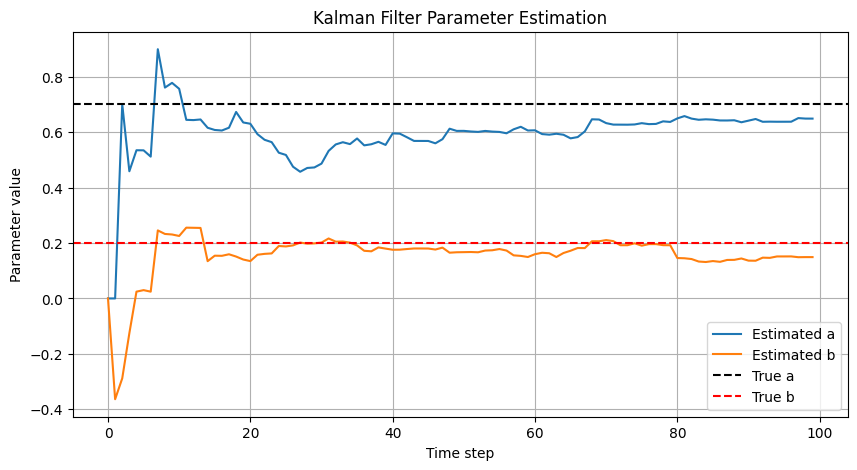

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
np.random.seed(42)
N = 100
a_true, b_true = 0.7, 0.2
v_var = 0.05  # measurement noise variance

# Generate input signal
u = np.random.randn(N)

# Simulate system
y = np.zeros(N)
for k in range(1, N):
    y[k] = a_true * y[k-1] + b_true * u[k-1] + np.sqrt(v_var)*np.random.randn()

# Kalman filter initialization
theta_hat = np.zeros((2, N))  # parameter estimates [a, b]
P = np.eye(2)
Q = 1e-4 * np.eye(2)  # process noise covariance
R = v_var              # measurement noise covariance

# Kalman Filter loop
for k in range(1, N):
    phi = np.array([[y[k-1]], [u[k-1]]])  # regressor

    # Prediction
    theta_pred = theta_hat[:, k-1].reshape(-1,1)
    P_pred = P + Q

    # Kalman gain
    K = P_pred @ phi / (phi.T @ P_pred @ phi + R)

    # Measurement update
    y_pred = (phi.T @ theta_pred).item()
    theta_new = theta_pred + K * (y[k] - y_pred)
    P = (np.eye(2) - K @ phi.T) @ P_pred

    theta_hat[:, k] = theta_new.ravel()

# Plot results
plt.figure(figsize=(10,5))
plt.plot(theta_hat[0,:], label='Estimated a')
plt.plot(theta_hat[1,:], label='Estimated b')
plt.axhline(a_true, color='k', linestyle='--', label='True a')
plt.axhline(b_true, color='r', linestyle='--', label='True b')
plt.xlabel('Time step')
plt.ylabel('Parameter value')
plt.title('Kalman Filter Parameter Estimation')
plt.legend()
plt.grid(True)
plt.show()

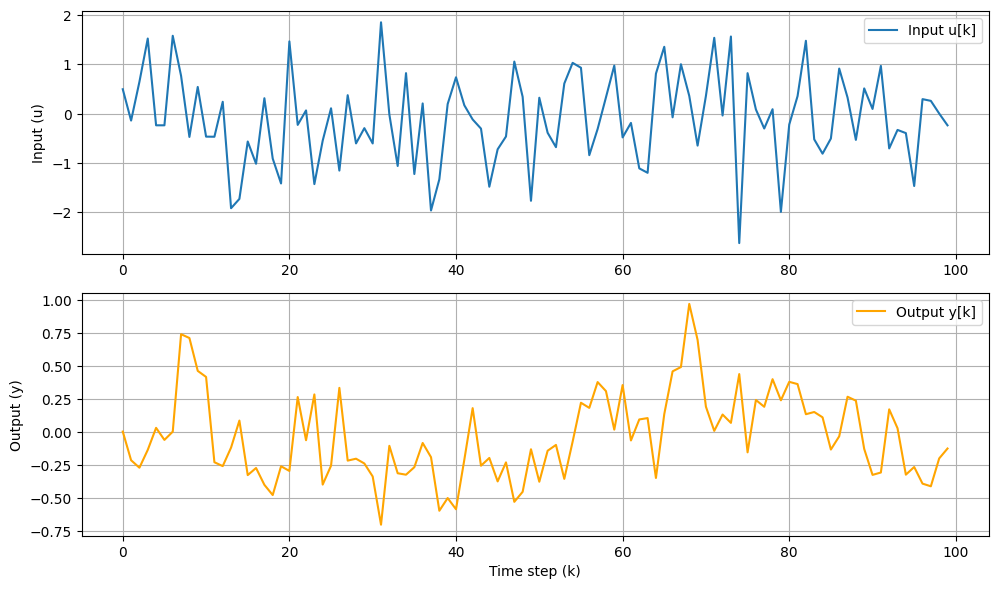

In [4]:
# Plot the simulated time series
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.plot(u, label='Input u[k]')
plt.ylabel('Input (u)')
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.plot(y, color='orange', label='Output y[k]')
plt.xlabel('Time step (k)')
plt.ylabel('Output (y)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:10: SyntaxWarning: invalid escape sequence '\h'
C:\Users\giacomg\AppData\Local\Temp\ipykernel_42260\2541619601.py:10: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(y_predicted, '--', label='Predicted output $\hat{y}[k]$', linewidth=2)


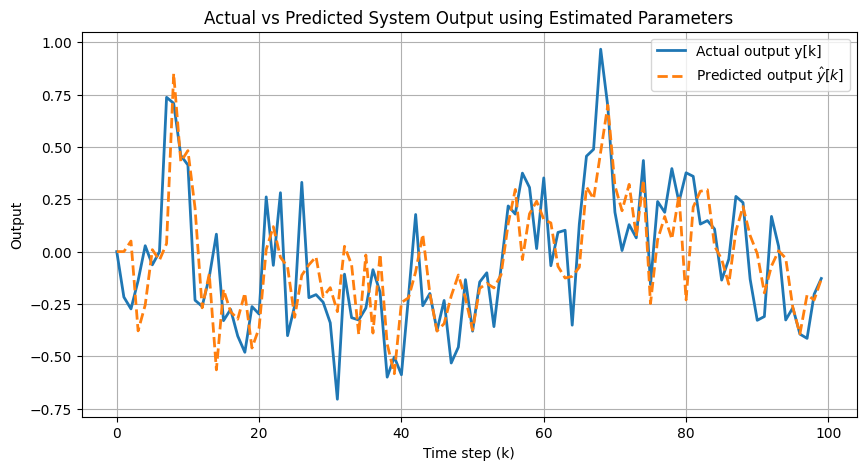

In [5]:
# Compute predicted output using estimated parameters
y_predicted = np.zeros(N)
for k in range(1, N):
    a_est, b_est = theta_hat[:, k-1]
    y_predicted[k] = a_est * y[k-1] + b_est * u[k-1]

# Plot actual vs predicted output
plt.figure(figsize=(10,5))
plt.plot(y, label='Actual output y[k]', linewidth=2)
plt.plot(y_predicted, '--', label='Predicted output $\hat{y}[k]$', linewidth=2)
plt.xlabel('Time step (k)')
plt.ylabel('Output')
plt.title('Actual vs Predicted System Output using Estimated Parameters')
plt.legend()
plt.grid(True)
plt.show()


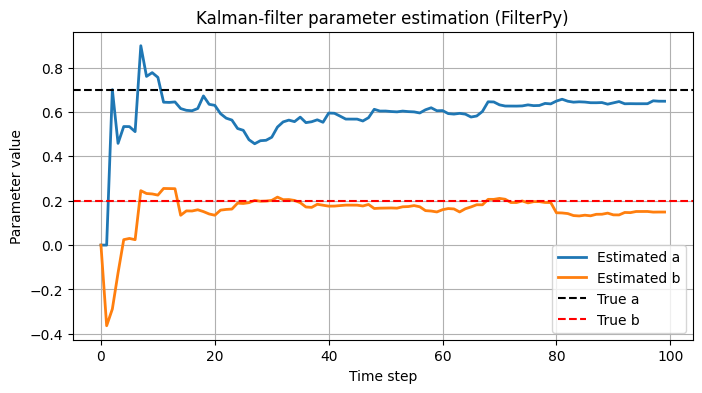

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# --------------------------------------------------------
# 1.  data generation (same as before)
# --------------------------------------------------------
np.random.seed(42)
N = 100
a_true, b_true, v_var = 0.7, 0.2, 0.05
u = np.random.randn(N)
y = np.zeros(N)
for k in range(1, N):
    y[k] = a_true * y[k-1] + b_true * u[k-1] + np.sqrt(v_var) * np.random.randn()

# --------------------------------------------------------
# 2.  FilterPy Kalman filter
# --------------------------------------------------------
kf = KalmanFilter(dim_x=2, dim_z=1)          # state = [a, b]ᵀ
kf.F = np.eye(2)                             # state-transition
kf.Q = 1e-4 * np.eye(2)                      # process-noise cov
kf.R = np.array([[v_var]])                   # measurement-noise cov
kf.x = np.array([[0.], [0.]])                # initial guess
kf.P = np.eye(2)                             # initial covariance

theta_hat = np.zeros((2, N))                 # store estimates
for k in range(1, N):
    kf.H = np.array([[y[k-1], u[k-1]]])      # regressor φᵀ
    kf.predict()
    kf.update(np.array([[y[k]]]))
    theta_hat[:, k] = kf.x.ravel()

# --------------------------------------------------------
# 3.  plot
# --------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(theta_hat[0], lw=2, label='Estimated a')
plt.plot(theta_hat[1], lw=2, label='Estimated b')
plt.axhline(a_true, ls='--', c='k', label='True a')
plt.axhline(b_true, ls='--', c='r', label='True b')
plt.xlabel('Time step')
plt.ylabel('Parameter value')
plt.title('Kalman-filter parameter estimation (FilterPy)')
plt.legend(); plt.grid(True); plt.show()